There are lots of different types of DMD now. Among them are 'streaming', or online DMD algorithms. These methods are very attractive because of their low memory usage, and their ability to operate incrementally on data streams.

First, we need to do some setup and get some data. We'll use the bus station dataset this time.

In [1]:
import os
import sys
import imageio
import numpy as np
import skimage
from skimage import io
from skimage import transform
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

from csdmd.StreamingSnapshots import SlidingDMD, StreamingSnapshots
from csdmd.SDMD import SDMD
from csdmd.STDMD import STDMD
# from pydmd import MrDMD, DMD

In [2]:
DATASET = os.path.join(os.curdir, "../data")
os.listdir(DATASET)

['peopleInShade',
 'backdoor',
 'busStation',
 'copyMachine',
 'PETS2006',
 'skating',
 'pedestrians',
 'office',
 'sofa',
 'cubicle']

In [3]:
def load_images(path, shape=None):
    files = os.listdir(path)
    data = None

    for f in files:
        fp = os.path.join(path, f)
        num = int(f[2:8])
        im = io.imread(fp, as_gray=True)
        if shape is not None:
            im = transform.resize(im, shape)
        if data is None:
            data = np.zeros((im.size, len(files)))
        elif num < data.shape[1]:
            data[:,num] = im.flatten()
            
    return data

In [4]:
# Investigate a single video: Pedestrians
# Was having memory problems, so controlled the image size with shape
# shape = (60,90);
shape = (120,180)
dt = 1  # Assumption
BUSSTATION = os.path.join(DATASET,'busStation/input')
ims = load_images(BUSSTATION, shape)
N = ims.shape[1]

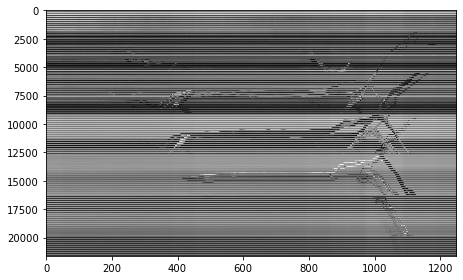

In [5]:
# This is what the data matrix looks like. Note that its very easy to pick out the pixels where 
# pedestrians are walking. However, they are pretty scattered and non-local. It would be interesting
# to try the tensor-based decomposition instead.

def plot_data(data):
    fig = io.imshow(np.real(data))
    fig.axes.set_aspect('auto')
    
def plot_image(im, shape=shape):
    io.imshow(im.clip(min=0,max=1).reshape(shape), vmin=0, vmax=1, cmap="gray")
    
plot_data(ims)


# Dynamic mode decomposition for large and streaming datasets - Hemati et al

The original! Abbrieviated as SDMD. 

There are 5 steps that this algorithm performs every iteration.
1. For each pair of data points, compute the residuals using the current bases. Use Gram-Schidt to ensure orthogonality
2. If one (or both) of the residuals are larger than the threshold, add the normalised residuals to the corresponding basis while zero padding the other matrices.
3. If either basis becomes too large, compute the leading eigvecs and diagonalise?
4. Update A, Gx, and Gy using the projected data.
5. Compute the DMD modes / eigenvalues



In [6]:
sdmd = SDMD(max_rank=3)

i = 250


251

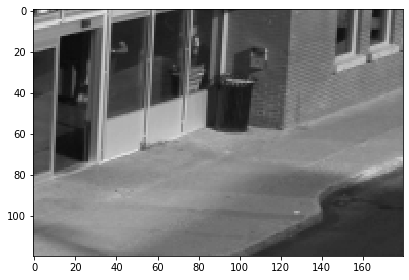

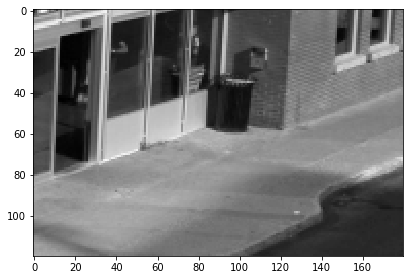

In [7]:
i += 1
if i > 0 and i < N:
    x, y = ims[:,i-1], ims[:,i]
    sdmd.stream(x,y)
    modes, eigvals = sdmd.compute_modes()
    if modes is not None:
        background = modes[:,0]
        background = np.interp(background.real, (background.min(), (background).max()), (0,1))
        plot_image(x)
        plt.figure()
        plot_image(background)

i

In [8]:

stdmd = STDMD(max_rank=10)

i = 250


251

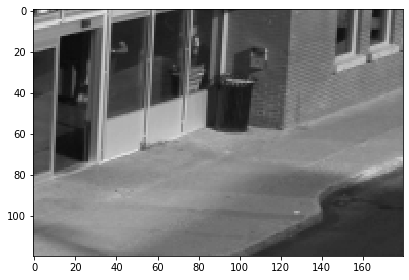

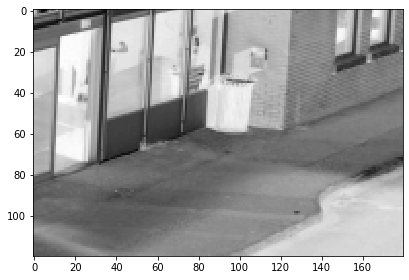

In [9]:
i += 1
if i > 0 and i < N:
    x, y = ims[:,i-1], ims[:,i]
    stdmd.stream(x,y)
    modes, eigvals = stdmd.compute_modes()
    if modes is not None:
        background = modes[:,0]
        background = np.interp(background.real, (background.min(), (background).max()), (0,1))
        plot_image(x)
        plt.figure()
        plot_image(background)

i

In [10]:

slidingdmd = SlidingDMD(max_rank=10, N=50)

i = 225


/opt/anaconda/envs/research/lib/python3.8/site-packages/numpy/lib/function_base.py:1423: ComplexWarning: Casting complex values to real discards the imaginary part
  return interp_func(x, xp, fp, left, right)


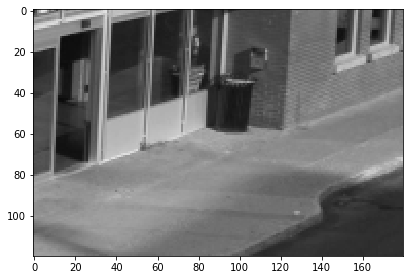

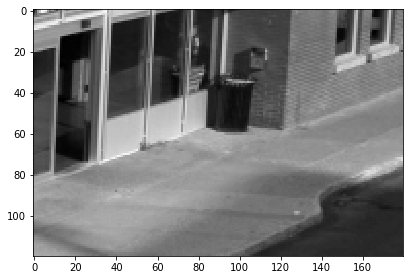

In [11]:
if i > 0 and i < N:
    x, y = ims[:,i-1], ims[:,i]
    ready = False
    while not ready:
        ready = slidingdmd.stream(x,y)
        i += 1
        
#         print(slidingdmd.XX[:5,:], end="\n\n")
    slidingdmd.compute_modes()
    if modes is not None:
        background = slidingdmd.reconstruct(0)
        background = np.interp(background.real, (background.min(), (background).max()), (0,1))
        plot_image(x)
        plt.figure()
        plot_image(background)



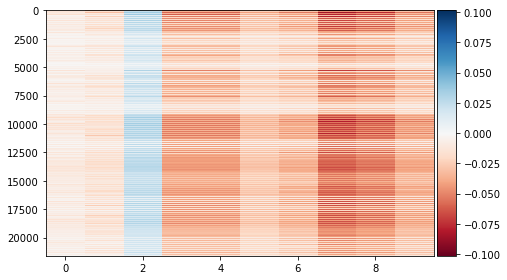

In [12]:
plot_data(slidingdmd.phi)

In [25]:

streamingsnapshots = StreamingSnapshots(max_rank=10, N=50)

i = 225


In [26]:
if i > 0 and i < N:
    x, y = ims[:,i-1], ims[:,i]
    ready = False
    while not ready:
        ready = streamingsnapshots.stream(x,y)
        i += 1
        
#         print(slidingdmd.XX[:5,:], end="\n\n")
    streamingsnapshots.compute_modes()
    if modes is not None:
        background = streamingsnapshots.reconstruct(0)
        background = np.interp(background.real, (background.min(), (background).max()), (0,1))
        plot_image(x)
        plt.figure()
        plot_image(background)



ValueError: operands could not be broadcast together with shapes (21600,) (49,49) 

In [17]:
streamingsnapshots._X

array([[0.19903885, 0.19903885, 0.19903885, ..., 0.19903885, 0.19903885,
        0.17815427],
       [0.29168643, 0.29168643, 0.29168643, ..., 0.29168643, 0.29168643,
        0.2923683 ],
       [0.59914032, 0.59914032, 0.59914032, ..., 0.59914032, 0.59914032,
        0.58808779],
       ...,
       [0.18385287, 0.18385287, 0.18385287, ..., 0.18385287, 0.18385287,
        0.18223163],
       [0.18071138, 0.18071138, 0.18071138, ..., 0.18071138, 0.18071138,
        0.18341414],
       [0.18316483, 0.18316483, 0.18316483, ..., 0.18316483, 0.18316483,
        0.17923846]])